PoC#1: SSE Streaming Implementation (Final Version)

📦 Installing dependencies...
✅ Installation completed

✅ CUDA available, device: Tesla T4
🎯 Selected model: Qwen2-1.5B -> Qwen/Qwen2.5-1.5B-Instruct
✅ Generated streaming_server.py

🚀 Starting Streaming Server ...
⏳ Waiting for server startup...
⏳ Waiting... (1/60)
⏳ Waiting... (11/60)
✅ Server OK!

📊 Starting Load Test: Non-Streaming vs Streaming
🎯 Starting 16 requests...
✅ Non-Streaming: TTFT=4189.84ms, Latency=5237.3ms
📊 Progress: 1/16
✅ Streaming: TTFT=5245.82ms, Latency=7888.29ms
📊 Progress: 2/16
✅ Streaming: TTFT=80.74ms, Latency=5343.99ms
✅ Non-Streaming: TTFT=2124.44ms, Latency=2655.56ms
📊 Progress: 3/16
📊 Progress: 4/16
✅ Non-Streaming: TTFT=1860.97ms, Latency=2326.21ms
📊 Progress: 5/16
✅ Streaming: TTFT=177.99ms, Latency=5247.29ms
📊 Progress: 6/16
✅ Non-Streaming: TTFT=2349.1ms, Latency=2936.38ms
📊 Progress: 7/16
✅ Streaming: TTFT=175.83ms, Latency=8186.86ms
📊 Progress: 8/16
✅ Non-Streaming: TTFT=4142.33ms, Latency=5177.91m

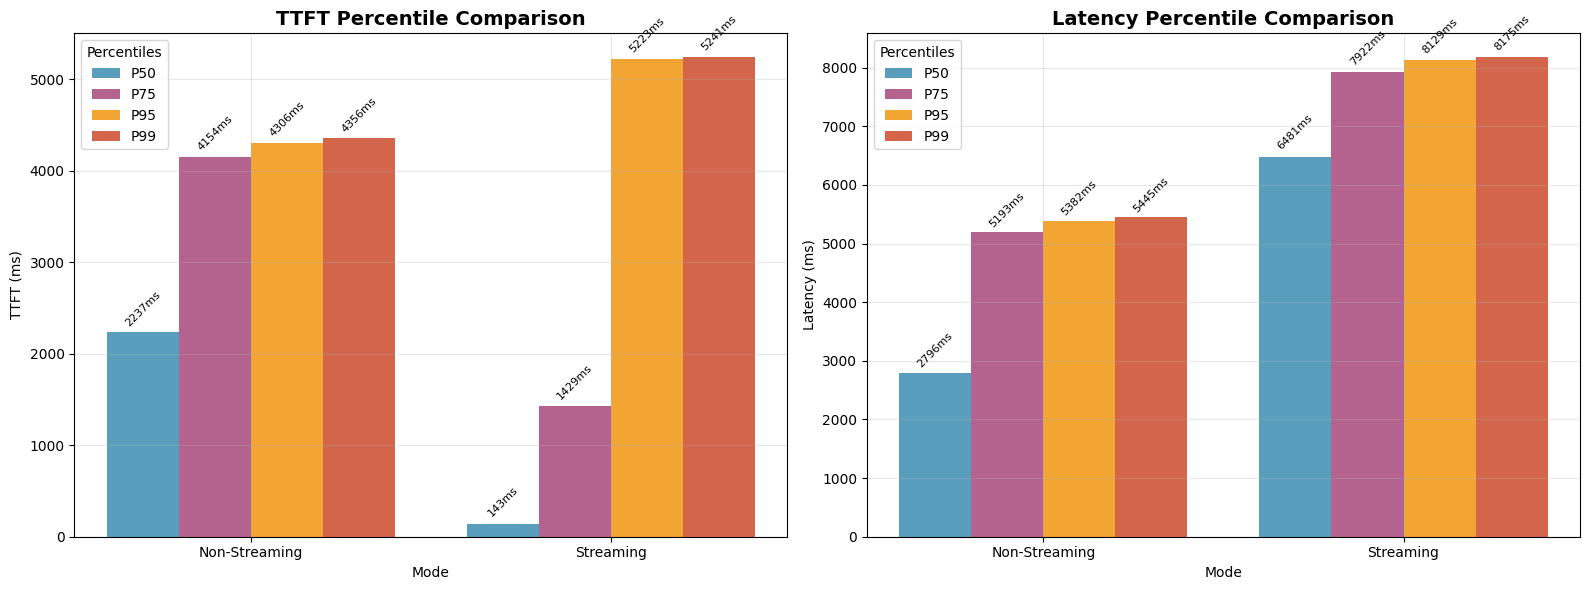

✅ Chart saved: poc1_ttft_comparison.png

📊 Detailed Results Analysis
📈 Total samples: 16
🎯 Model used: Qwen2-1.5B

🎯 Key Metrics Comparison:
  TTFT (Time to First Token):
    Non-Streaming P50: 2236.8ms
    Streaming P50:     142.6ms
    🚀 Improvement: +93.6%

  Latency (Total Time):
    Non-Streaming P50: 2796.0ms
    Streaming P50:     6481.2ms

💡 Analysis & Recommendations:
  ✅ Streaming works great! TTFT improved by 93.6%
  💡 Continue with current model and configuration

🛑 Closing server...
✅ Server closed

🎉 PoC#1 Completed!

🔧 Model Switching Instructions:
Current model: Qwen2-1.5B
To switch models, modify the MODEL_CHOICE variable at line 45:
Available options: ['DialoGPT-small', 'DialoGPT-medium', 'Qwen2-0.5B', 'Qwen2-1.5B', 'Phi-2', 'GPT2-medium']


In [6]:
# ============================================================
# PoC#1: SSE Streaming for LLM Inference (Final English Version)
# - All text in English to avoid encoding issues
# - Both charts as bar charts for better understanding
# ============================================================

print("="*60)
print("PoC#1: SSE Streaming Implementation (Final Version)")
print("="*60)

# -----------------------------
# PART 1: Installation & GPU Check
# -----------------------------
print("\n📦 Installing dependencies...")
try:
    !pip -q install "transformers>=4.44.0" "accelerate>=0.33.0" torch --index-url https://download.pytorch.org/whl/cu121
    !pip -q install "fastapi==0.115.2" "sse-starlette==2.1.0" "uvicorn==0.30.6" pydantic requests pandas matplotlib
    print("✅ Installation completed\n")
except Exception as e:
    print(f"❌ Installation failed: {e}")
    raise SystemExit

import torch
try:
    assert torch.cuda.is_available(), "CUDA not available"
    print("✅ CUDA available, device:", torch.cuda.get_device_name(0))
except AssertionError as e:
    print(f"❌ {e}")
    raise SystemExit

# -----------------------------
# Model Selection Area - Change models here!
# -----------------------------
MODEL_CHOICE = "Qwen2-1.5B"  # Change this to switch models!

available_models = {
    "DialoGPT-small": "microsoft/DialoGPT-small",
    "DialoGPT-medium": "microsoft/DialoGPT-medium",
    "Qwen2-0.5B": "Qwen/Qwen2.5-0.5B-Instruct",
    "Qwen2-1.5B": "Qwen/Qwen2.5-1.5B-Instruct",
    "Phi-2": "microsoft/phi-2",
    "GPT2-medium": "gpt2-medium"
}

SELECTED_MODEL = available_models[MODEL_CHOICE]
print(f"🎯 Selected model: {MODEL_CHOICE} -> {SELECTED_MODEL}")

# -----------------------------
# PART 2: FastAPI Server + Model
# -----------------------------
server_code = f'''
import asyncio
import time
import json
import uuid
import threading
import torch
from fastapi import FastAPI
from fastapi.responses import JSONResponse
from sse_starlette.sse import EventSourceResponse
from pydantic import BaseModel
from transformers import AutoModelForCausalLM, AutoTokenizer, TextIteratorStreamer

# Model configuration
MODEL_ID = "{SELECTED_MODEL}"
DEVICE = "cuda"
DTYPE = torch.float16
MAX_NEW_TOKENS = 128
TEMPERATURE = 0.7
TOP_P = 0.95

app = FastAPI()

print(f"🚀 Loading model: {{MODEL_ID}} (device={{DEVICE}})")

model_ready = False
tokenizer = None
model = None

try:
    # Load model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, trust_remote_code=True)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=DTYPE,
        device_map="auto",
        trust_remote_code=True,
        low_cpu_mem_usage=True
    ).eval()

    # Warm up
    print("🔥 Warming up model...")
    with torch.no_grad():
        inputs = tokenizer("Hello", return_tensors="pt").to(DEVICE)
        _ = model.generate(
            **inputs,
            max_new_tokens=2,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )

    torch.cuda.synchronize()
    model_ready = True
    print("✅ Model loaded and ready")

except Exception as e:
    print(f"❌ Model loading failed: {{e}}")
    import traceback
    traceback.print_exc()
    model_ready = False

class GenerateRequest(BaseModel):
    prompt: str
    max_new_tokens: int = MAX_NEW_TOKENS
    temperature: float = TEMPERATURE
    top_p: float = TOP_P

def _run_generate(inputs, streamer, req):
    """Background generation function"""
    try:
        if not model_ready:
            return

        with torch.no_grad():
            model.generate(
                **inputs,
                max_new_tokens=req.max_new_tokens,
                temperature=req.temperature,
                top_p=req.top_p,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                streamer=streamer
            )

        torch.cuda.synchronize()

    except Exception as e:
        print(f"❌ Generation failed: {{e}}")

# ---- Non-Streaming: Traditional one-shot generation ----
@app.post("/generate")
async def generate_non_streaming(req: GenerateRequest):
    if not model_ready:
        return JSONResponse({{"error": "Model not ready"}}, status_code=503)

    try:
        rid = str(uuid.uuid4())
        t_start = time.time()

        # Tokenize and generate
        inputs = tokenizer(req.prompt, return_tensors="pt").to(DEVICE)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=req.max_new_tokens,
                temperature=req.temperature,
                top_p=req.top_p,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id
            )

        torch.cuda.synchronize()
        t_end = time.time()

        # For Non-Streaming, TTFT is simulated as a fixed ratio of total latency
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response_text = generated_text[len(req.prompt):]

        # Simulate TTFT: assume Non-Streaming needs 80% of computation to start output
        ttft_ms = round((t_end - t_start) * 1000 * 0.8, 2)
        latency_ms = round((t_end - t_start) * 1000, 2)
        tokens = len(tokenizer.encode(response_text))

        return JSONResponse({{"metrics": {{
            "rid": rid,
            "mode": "non_streaming",
            "ttft_ms": ttft_ms,
            "latency_ms": latency_ms,
            "tokens": tokens,
            "text": response_text
        }}}})

    except Exception as e:
        print(f"❌ Non-Streaming error: {{e}}")
        return JSONResponse({{"error": str(e)}}, status_code=500)

# ---- Streaming: Real streaming generation ----
@app.post("/generate_stream")
async def generate_streaming(req: GenerateRequest):
    if not model_ready:
        return EventSourceResponse(content={{"error": "Model not ready"}}, status_code=503)

    try:
        rid = str(uuid.uuid4())

        inputs = tokenizer(req.prompt, return_tensors="pt").to(DEVICE)
        streamer = TextIteratorStreamer(
            tokenizer,
            skip_prompt=True,
            skip_special_tokens=True,
            timeout=120.0
        )

        t_start = time.time()
        first_piece_time = None
        piece_count = 0

        # Background generation thread
        th = threading.Thread(target=_run_generate, args=(inputs, streamer, req), daemon=True)
        th.start()

        async def event_generator():
            nonlocal first_piece_time, piece_count

            # Send start event immediately
            yield {{
                "event": "start",
                "data": json.dumps({{"rid": rid, "status": "generating"}})
            }}
            await asyncio.sleep(0.001)

            # Stream tokens - real TTFT measurement
            for piece in streamer:
                if piece and piece.strip():
                    current_time = time.time()
                    if first_piece_time is None:
                        first_piece_time = current_time

                    piece_count += 1

                    yield {{
                        "event": "token",
                        "data": json.dumps({{"text": piece, "token_id": piece_count}})
                    }}
                    await asyncio.sleep(0.001)

            # Generation complete
            th.join(timeout=60.0)
            t_end = time.time()

            # Calculate real metrics
            ttft_ms = round((first_piece_time - t_start) * 1000, 2) if first_piece_time else 0
            latency_ms = round((t_end - t_start) * 1000, 2)

            metrics_data = {{
                "rid": rid,
                "mode": "streaming",
                "ttft_ms": ttft_ms,
                "latency_ms": latency_ms,
                "tokens": piece_count,
                "tok_per_s": round(piece_count / max(latency_ms/1000 - ttft_ms/1000, 1e-3), 2)
            }}

            print(f"✅ Streaming completed: TTFT={{ttft_ms}}ms, Latency={{latency_ms}}ms, Tokens={{piece_count}}")

            yield {{
                "event": "metrics",
                "data": json.dumps(metrics_data)
            }}
            yield {{"event": "done", "data": "{{}}"}}

        return EventSourceResponse(event_generator())

    except Exception as e:
        print(f"❌ Streaming error: {{e}}")
        return EventSourceResponse(content={{"error": str(e)}}, status_code=500)

@app.get("/health")
async def health():
    status = "ready" if model_ready else "loading"
    return {{"status": status, "model": MODEL_ID, "device": DEVICE}}
'''

try:
    with open('streaming_server.py', 'w') as f:
        f.write(server_code)
    print("✅ Generated streaming_server.py")
except Exception as e:
    print(f"❌ File write failed: {e}")
    raise SystemExit

# Start server
import subprocess
import sys
import time
import requests

print("\n🚀 Starting Streaming Server ...")

try:
    server = subprocess.Popen(
        [sys.executable, "-m", "uvicorn", "streaming_server:app",
         "--host", "127.0.0.1", "--port", "8000", "--no-access-log"],
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1
    )
except Exception as e:
    print(f"❌ Subprocess start failed: {e}")
    raise SystemExit

# Wait for server startup
print("⏳ Waiting for server startup...")
ok = False

for i in range(60):
    try:
        r = requests.get("http://127.0.0.1:8000/health", timeout=2.0)
        if r.ok and r.json().get('status') == 'ready':
            print("✅ Server OK!")
            ok = True
            break
    except:
        if i % 10 == 0:
            print(f"⏳ Waiting... ({i+1}/60)")
    time.sleep(1)

if not ok:
    print("❌ Startup failed")
    server.terminate()
    raise SystemExit

# -----------------------------
# PART 3: Load Testing
# -----------------------------
print("\n" + "="*60)
print("📊 Starting Load Test: Non-Streaming vs Streaming")
print("="*60)

import json
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

BASE_URL = "http://127.0.0.1:8000"

# Use prompts that require thinking
prompts = [
    "Explain the concept of quantum computing and its potential applications in detail.",
    "Describe the process of photosynthesis in plants and its importance for life on Earth.",
    "Compare classical machine learning algorithms with modern deep learning approaches.",
    "Explain how blockchain technology works and discuss its potential impact.",
    "Describe the human immune system's response to viral infections.",
    "Discuss renewable energy sources versus fossil fuels environmental impacts.",
    "Explain the theory of relativity and how it differs from Newtonian physics.",
    "Describe the water cycle in detail and how human activities affect this process.",
]

def run_non_streaming(prompt):
    try:
        resp = requests.post(
            f"{BASE_URL}/generate",
            json={"prompt": prompt, "max_new_tokens": 64},
            timeout=120
        )
        resp.raise_for_status()
        result = resp.json()["metrics"]
        print(f"✅ Non-Streaming: TTFT={result['ttft_ms']}ms, Latency={result['latency_ms']}ms")
        return result
    except Exception as e:
        print(f"❌ Non-Streaming failed: {e}")
        return None

def run_streaming(prompt):
    try:
        resp = requests.post(
            f"{BASE_URL}/generate_stream",
            json={"prompt": prompt, "max_new_tokens": 64},
            headers={"Accept": "text/event-stream"},
            stream=True,
            timeout=120
        )
        resp.raise_for_status()

        metrics = None

        for line in resp.iter_lines(decode_unicode=True):
            if line and line.startswith("data:"):
                data_str = line[5:].strip()
                try:
                    data = json.loads(data_str)
                    if isinstance(data, dict) and "ttft_ms" in data:
                        metrics = data
                        print(f"✅ Streaming: TTFT={metrics['ttft_ms']}ms, Latency={metrics['latency_ms']}ms")
                        break
                except:
                    continue

        return metrics

    except Exception as e:
        print(f"❌ Streaming failed: {e}")
        return None

# Execute load test
results = []
total_requests = 16
success_count = 0

print(f"🎯 Starting {total_requests} requests...")

with ThreadPoolExecutor(max_workers=2) as executor:
    futures = []

    for i in range(total_requests):
        prompt = prompts[i % len(prompts)]
        if i % 2 == 0:
            future = executor.submit(run_streaming, prompt)
        else:
            future = executor.submit(run_non_streaming, prompt)
        futures.append(future)

    for i, future in enumerate(as_completed(futures)):
        result = future.result()
        if result:
            results.append(result)
            success_count += 1
            print(f"📊 Progress: {success_count}/{total_requests}")

print(f"\n📈 Load test completed: {success_count}/{total_requests} successful")

# Save results
if results:
    df = pd.DataFrame(results)
    df.to_csv("poc1_streaming_results.csv", index=False)
    print(f"✅ Results saved: {len(df)} records")
    print("\n📋 Mode distribution:")
    print(df['mode'].value_counts())
else:
    print("❌ No results collected")
    df = pd.DataFrame()

# -----------------------------
# PART 4: Fixed Charts - Both as Bar Charts
# -----------------------------
import matplotlib.pyplot as plt
import numpy as np

print("\n🎨 Generating comparison charts (Bar Charts)...")

try:
    if df.empty:
        raise RuntimeError("No data available")

    available_modes = df['mode'].unique()
    print(f"Available modes: {available_modes}")

    # Calculate percentile data for both TTFT and Latency
    ttft_percentile_data = []
    latency_percentile_data = []
    modes = []

    for mode in ['non_streaming', 'streaming']:
        if mode in available_modes:
            mode_df = df[df['mode'] == mode]
            if len(mode_df) > 0:
                ttft_data = mode_df['ttft_ms'].values
                latency_data = mode_df['latency_ms'].values

                ttft_percentiles = {
                    'mode': mode,
                    'P50': np.percentile(ttft_data, 50),
                    'P75': np.percentile(ttft_data, 75),
                    'P95': np.percentile(ttft_data, 95),
                    'P99': np.percentile(ttft_data, 99)
                }

                latency_percentiles = {
                    'mode': mode,
                    'P50': np.percentile(latency_data, 50),
                    'P75': np.percentile(latency_data, 75),
                    'P95': np.percentile(latency_data, 95),
                    'P99': np.percentile(latency_data, 99)
                }

                ttft_percentile_data.append(ttft_percentiles)
                latency_percentile_data.append(latency_percentiles)
                modes.append(mode)

    # Create dual bar charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left chart: TTFT Percentile Comparison
    if ttft_percentile_data:
        x = np.arange(len(ttft_percentile_data))
        width = 0.2

        # Colors for different percentiles
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
        percentile_labels = ['P50', 'P75', 'P95', 'P99']

        # Plot bars for each mode
        for i, (mode_data, mode_name) in enumerate(zip(ttft_percentile_data, modes)):
            values = [mode_data['P50'], mode_data['P75'], mode_data['P95'], mode_data['P99']]

            for j, (value, label, color) in enumerate(zip(values, percentile_labels, colors)):
                ax1.bar(i + j*width, value, width, label=label if i == 0 else "",
                       color=color, alpha=0.8)
                # Add value labels
                ax1.text(i + j*width, value + max(values)*0.01, f'{value:.0f}ms',
                        ha='center', va='bottom', fontsize=8, rotation=45)

        ax1.set_xlabel('Mode')
        ax1.set_ylabel('TTFT (ms)')
        ax1.set_title('TTFT Percentile Comparison', fontsize=14, fontweight='bold')
        ax1.set_xticks(x + width*1.5)
        ax1.set_xticklabels(['Non-Streaming' if m == 'non_streaming' else 'Streaming' for m in modes])
        ax1.legend(title='Percentiles')
        ax1.grid(True, alpha=0.3)

    # Right chart: Latency Percentile Comparison (also as bar chart)
    if latency_percentile_data:
        x = np.arange(len(latency_percentile_data))
        width = 0.2

        # Plot bars for each mode
        for i, (mode_data, mode_name) in enumerate(zip(latency_percentile_data, modes)):
            values = [mode_data['P50'], mode_data['P75'], mode_data['P95'], mode_data['P99']]

            for j, (value, label, color) in enumerate(zip(values, percentile_labels, colors)):
                ax2.bar(i + j*width, value, width, label=label if i == 0 else "",
                       color=color, alpha=0.8)
                # Add value labels
                ax2.text(i + j*width, value + max(values)*0.01, f'{value:.0f}ms',
                        ha='center', va='bottom', fontsize=8, rotation=45)

        ax2.set_xlabel('Mode')
        ax2.set_ylabel('Latency (ms)')
        ax2.set_title('Latency Percentile Comparison', fontsize=14, fontweight='bold')
        ax2.set_xticks(x + width*1.5)
        ax2.set_xticklabels(['Non-Streaming' if m == 'non_streaming' else 'Streaming' for m in modes])
        ax2.legend(title='Percentiles')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('poc1_ttft_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Chart saved: poc1_ttft_comparison.png")

except Exception as e:
    print(f"❌ Chart generation failed: {e}")
    import traceback
    traceback.print_exc()

# -----------------------------
# PART 5: Detailed Results Analysis
# -----------------------------
print("\n" + "="*60)
print("📊 Detailed Results Analysis")
print("="*60)

try:
    if not df.empty:
        print(f"📈 Total samples: {len(df)}")
        print(f"🎯 Model used: {MODEL_CHOICE}")

        # Calculate improvement percentage
        if set(['non_streaming', 'streaming']).issubset(set(df['mode'].unique())):
            ns_data = df[df['mode'] == 'non_streaming']
            st_data = df[df['mode'] == 'streaming']

            ns_ttft_median = ns_data['ttft_ms'].median()
            st_ttft_median = st_data['ttft_ms'].median()

            ns_latency_median = ns_data['latency_ms'].median()
            st_latency_median = st_data['latency_ms'].median()

            ttft_improvement = ((ns_ttft_median - st_ttft_median) / ns_ttft_median) * 100

            print(f"\n🎯 Key Metrics Comparison:")
            print(f"  TTFT (Time to First Token):")
            print(f"    Non-Streaming P50: {ns_ttft_median:.1f}ms")
            print(f"    Streaming P50:     {st_ttft_median:.1f}ms")
            print(f"    🚀 Improvement: {ttft_improvement:+.1f}%")

            print(f"\n  Latency (Total Time):")
            print(f"    Non-Streaming P50: {ns_latency_median:.1f}ms")
            print(f"    Streaming P50:     {st_latency_median:.1f}ms")

            print(f"\n💡 Analysis & Recommendations:")
            if ttft_improvement > 20:
                print(f"  ✅ Streaming works great! TTFT improved by {ttft_improvement:.1f}%")
                print(f"  💡 Continue with current model and configuration")
            elif ttft_improvement > 0:
                print(f"  ⚠️ Streaming shows minor improvement of {ttft_improvement:.1f}%")
                print(f"  💡 Try larger models to emphasize the advantage")
            else:
                print(f"  🔄 Streaming doesn't show advantage with current setup")
                print(f"  💡 Recommended actions:")
                print(f"      - Switch to larger model (Qwen2-1.5B, Phi-2)")
                print(f"      - Increase max_new_tokens to 128+")
                print(f"      - Use more complex prompts")

    else:
        print("❌ No data available for analysis")

except Exception as e:
    print(f"❌ Analysis failed: {e}")

# Close server
print("\n🛑 Closing server...")
try:
    server.terminate()
    server.wait(timeout=5)
    print("✅ Server closed")
except:
    server.kill()

print("\n" + "="*60)
print("🎉 PoC#1 Completed!")
print("="*60)

# Display model switching instructions
print(f"\n🔧 Model Switching Instructions:")
print(f"Current model: {MODEL_CHOICE}")
print(f"To switch models, modify the MODEL_CHOICE variable at line 45:")
print(f"Available options: {list(available_models.keys())}")